In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random, math
import seaborn as sns
import os
import cv2

import tensorflow
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA

2023-05-14 16:42:38.738123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tensorflow.__version__)

2.12.0


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ls /content/drive/'My Drive'/'RMIT PROGRAMMING'/'Machine Learning A2'/

In [ ]:
# cd /content/drive/'My Drive'/'RMIT PROGRAMMING'/'Machine Learning A2'/

In [ ]:
# ls

In [ ]:
# pwd

In [3]:
dfMain = pd.read_csv('Image_classification_data/data_labels_mainData.csv')
dfExtra = pd.read_csv('Image_classification_data/data_labels_extraData.csv')
dfJoined = pd.concat([dfMain, dfExtra])
display(dfJoined)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0
...,...,...,...,...,...,...
10379,20028,99,20028.png,NaN,NaN,0
10380,20029,99,20029.png,NaN,NaN,0
10381,20030,99,20030.png,NaN,NaN,0
10382,20031,99,20031.png,NaN,NaN,0


In [4]:
dfJoined.shape

(20280, 6)

In [5]:
dfJoined.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0


In [6]:
dfJoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 0 to 10383
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   InstanceID    20280 non-null  int64  
 1   patientID     20280 non-null  int64  
 2   ImageName     20280 non-null  object 
 3   cellTypeName  9896 non-null   object 
 4   cellType      9896 non-null   float64
 5   isCancerous   20280 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


In [7]:
dfJoined.describe()

,InstanceID,patientID,cellType,isCancerous
count,20280.000000,20280.000000,9896.000000,20280.000000
mean,11163.660848,55.681065,1.501516,0.348570
std,6481.457867,28.891837,0.954867,0.476529
min,1.000000,1.000000,0.000000,0.000000
25%,5551.750000,29.000000,1.000000,0.000000
50%,11111.500000,63.000000,2.000000,0.000000
75%,16756.250000,81.000000,2.000000,1.000000
max,22444.000000,99.000000,3.000000,1.000000


In [8]:
dfJoined.dtypes

InstanceID        int64
patientID         int64
ImageName        object
cellTypeName     object
cellType        float64
isCancerous       int64
dtype: object

In [9]:
dfJoined.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

In [10]:
dfJoined.isnull().sum()

InstanceID          0
patientID           0
ImageName           0
cellTypeName    10384
cellType        10384
isCancerous         0
dtype: int64

([0, 1, 2, 3],
 [Text(0, 0, 'fibroblast'),
  Text(1, 0, 'inflammatory'),
  Text(2, 0, 'others'),
  Text(3, 0, 'epithelial')])

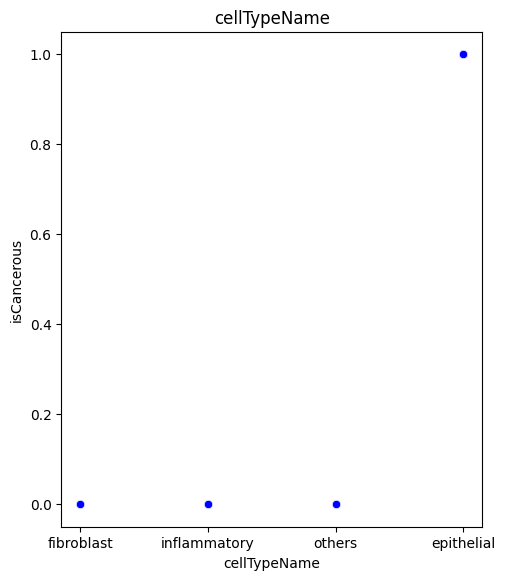

In [75]:
plt.figure(figsize=(25,45))
plt.subplot(6,4,1)
sns.scatterplot(data=dfMain, x=dfMain['cellTypeName'], y='isCancerous', color='blue')
plt.title('cellTypeName')
plt.xticks(rotation='horizontal')

<Axes: xlabel='Is Cancerous'>

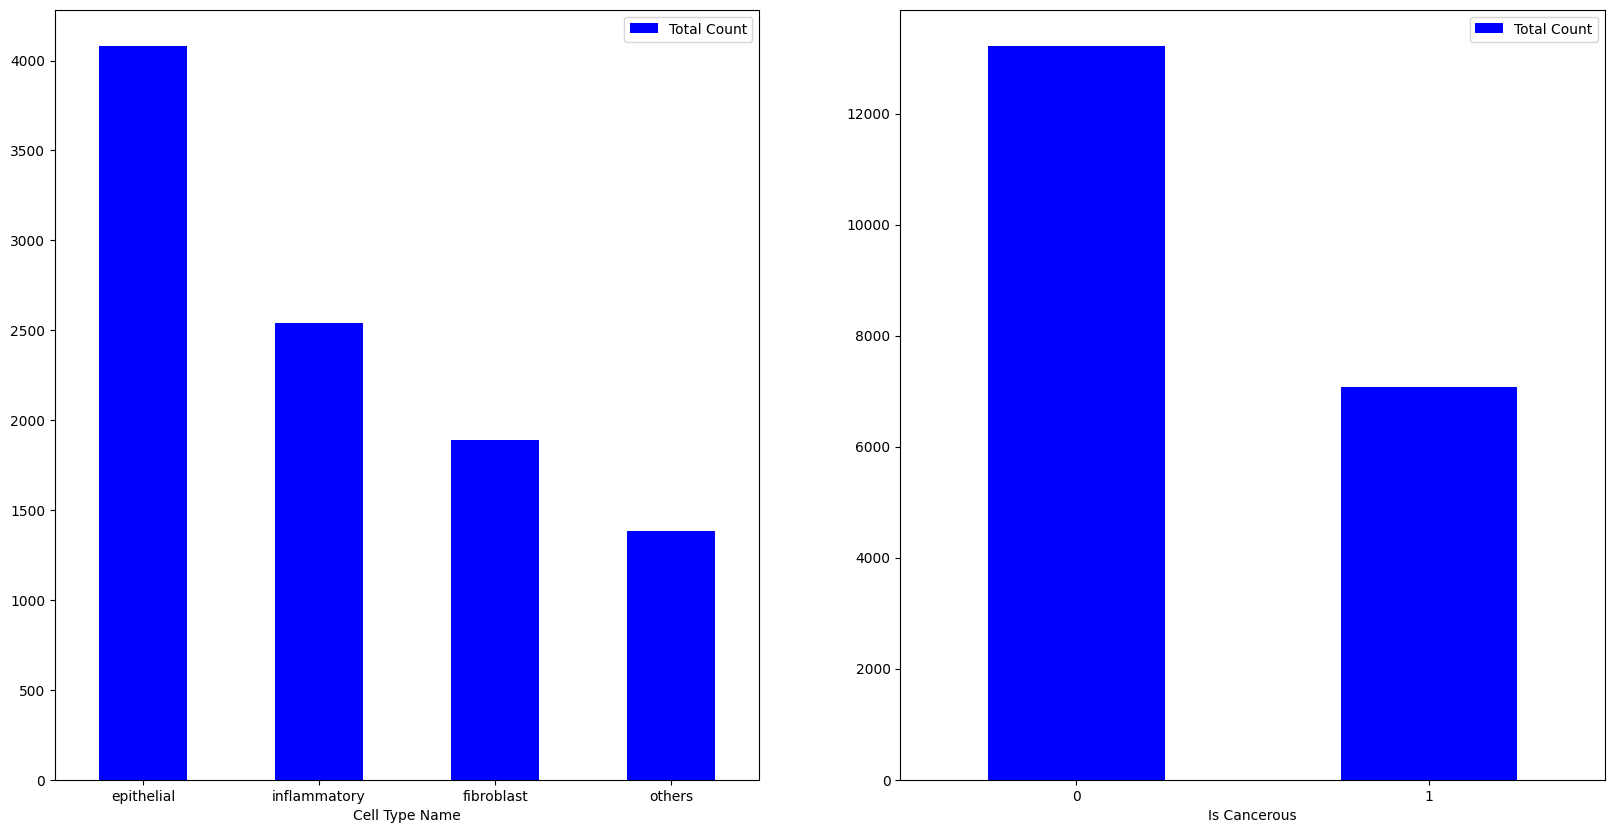

In [73]:
dfCellCounts = pd.DataFrame(dfMain.cellTypeName.value_counts().reset_index().values, columns=['Cell Type Name', 'Total Count'])
dfCancerousCounts = pd.DataFrame(dfJoined.isCancerous.value_counts().reset_index().values, columns=['Is Cancerous', 'Total Count'])
dfPatientImagesCount = pd.DataFrame(dfJoined.patientID.value_counts().reset_index().values, columns=['Patient ID', 'Total Images for Patient'])
dfPatientImagesCount = dfPatientImagesCount.sort_values('Patient ID', ascending=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
dfCellCounts.plot(kind='bar', x='Cell Type Name', y='Total Count', color='blue', ax=axes[0], rot=0)
dfCancerousCounts.plot(kind='bar', x='Is Cancerous', y='Total Count', color='blue', ax=axes[1], rot=0)

<Axes: xlabel='Patient ID'>

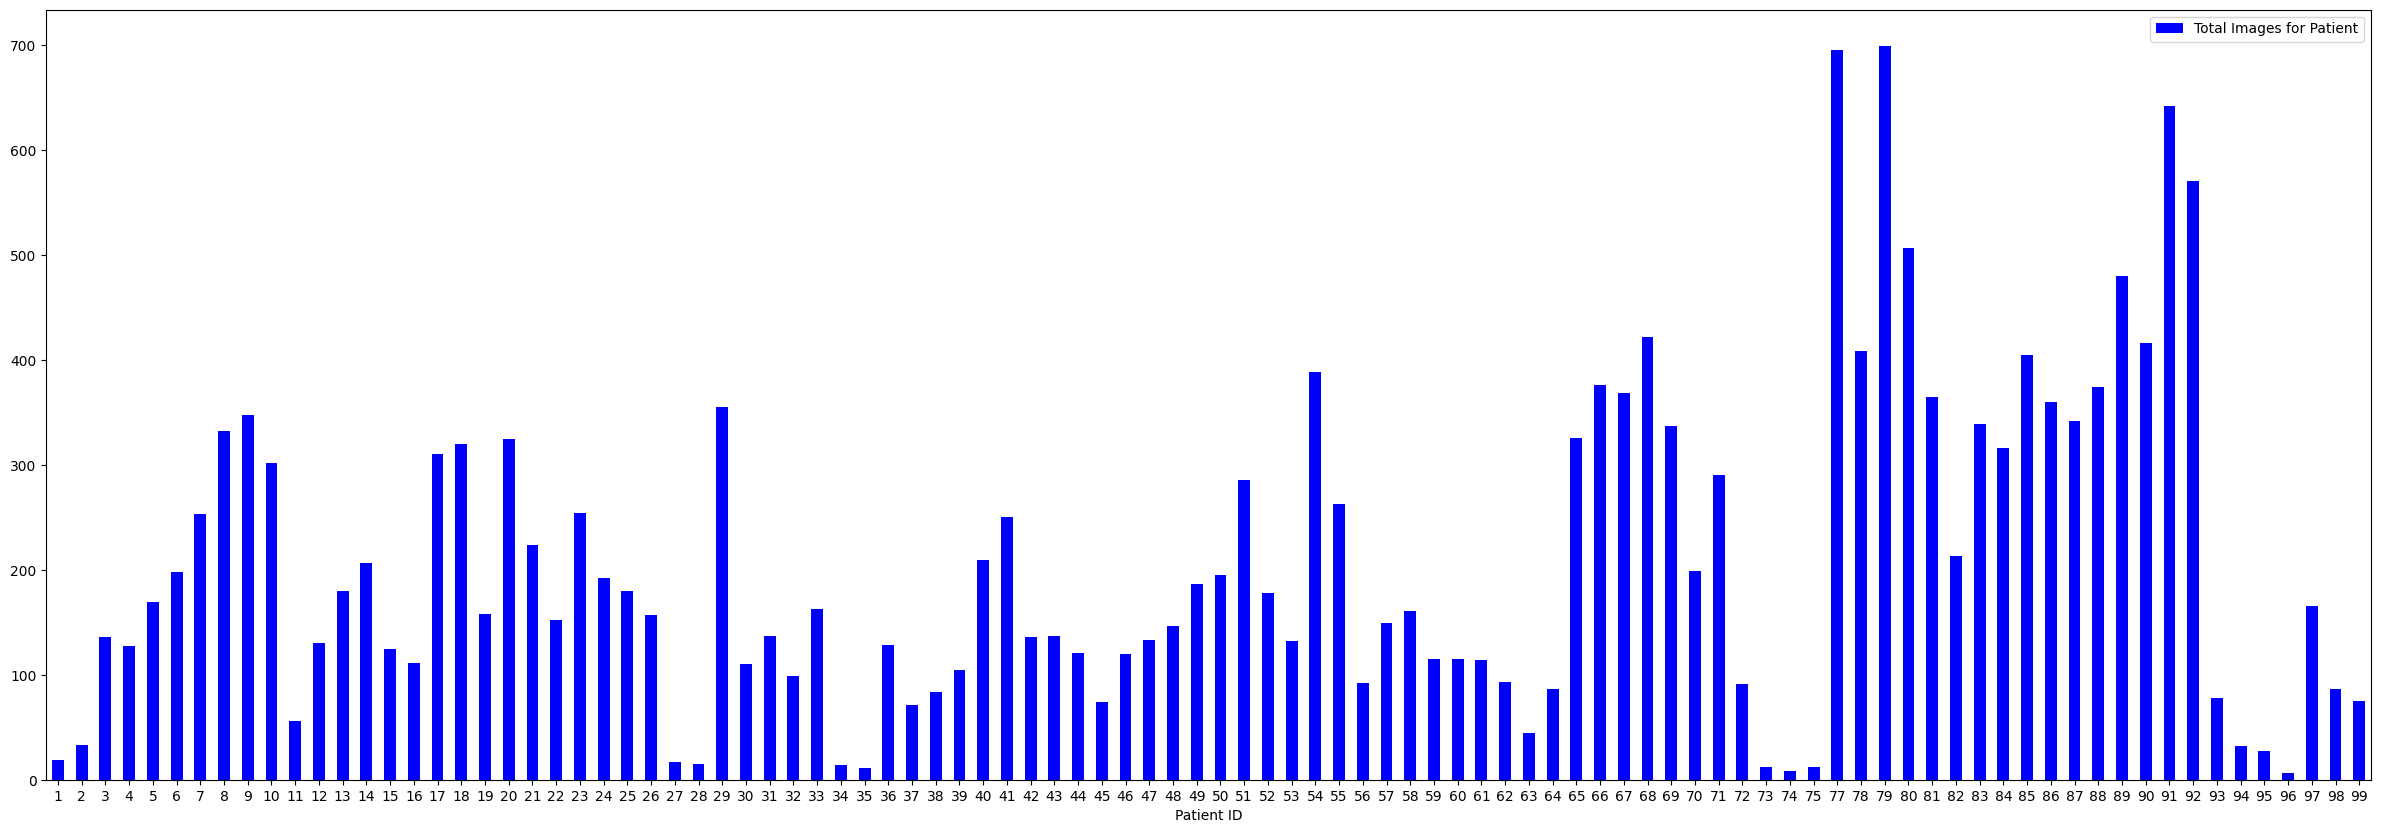

In [13]:
dfPatientImagesCount.plot(kind='bar', x='Patient ID', y='Total Images for Patient', color='blue', figsize=(30, 10), rot=0)

In [14]:
print("Average number of images per patient ID: ", dfPatientImagesCount['Total Images for Patient'].mean().round())

Average number of images per patient ID:  207.0


In [15]:
moreThan350 = []
lessThan100 = []
theRest = []

print("DF LENGTH: ", len(dfPatientImagesCount))

for index, patient in dfPatientImagesCount.iterrows():
    imageCount = patient['Total Images for Patient'].astype('int')
    if imageCount > 350: 
        moreThan350.append(patient['Patient ID'])
    elif imageCount < 100:
        lessThan100.append(patient['Patient ID'])
    else:
        theRest.append(patient['Patient ID'])

print(moreThan350)
print(lessThan100)
print(theRest)

total = len(moreThan350) + len(lessThan100) + len(theRest)
print("Total: ", total)

DF LENGTH:  98
[29, 54, 66, 67, 68, 77, 78, 79, 80, 81, 85, 86, 88, 89, 90, 91, 92]
[1, 2, 11, 27, 28, 32, 34, 35, 37, 38, 45, 56, 62, 63, 64, 72, 73, 74, 75, 93, 94, 95, 96, 98, 99]
[3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 31, 33, 36, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60, 61, 65, 69, 70, 71, 82, 83, 84, 87, 97]
Total:  98


In [16]:
def customSplitter(list, train):
    random.shuffle(list)
    splitIndex = math.ceil(len(list) * train) 
    training = list[:splitIndex]
    testing = list[splitIndex:]
    return training, testing

In [17]:
splits1 = customSplitter(moreThan350, 0.7)
splits2 = customSplitter(lessThan100, 0.7)
splits3 = customSplitter(theRest, 0.7)

trainingPatientID = splits1[0] + splits2[0] + splits3[0]
testingPatientID = splits1[1] + splits2[1] + splits3[1]
print(trainingPatientID)
print(testingPatientID)

[86, 78, 77, 88, 80, 90, 29, 91, 66, 67, 92, 79, 74, 38, 94, 72, 75, 99, 95, 45, 27, 28, 34, 98, 96, 93, 62, 56, 37, 73, 47, 21, 24, 53, 22, 30, 61, 31, 44, 50, 33, 42, 87, 84, 48, 40, 16, 18, 71, 52, 5, 13, 59, 82, 14, 83, 4, 55, 3, 69, 20, 15, 7, 60, 51, 36, 23, 8, 43, 26]
[54, 81, 89, 68, 85, 64, 1, 35, 32, 2, 63, 11, 57, 25, 41, 10, 58, 70, 49, 46, 97, 9, 12, 6, 65, 19, 17, 39]


/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_46571/1557139622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['Colour'] = 'blue'
/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_46571/1557139622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set['Colour'] = 'red'


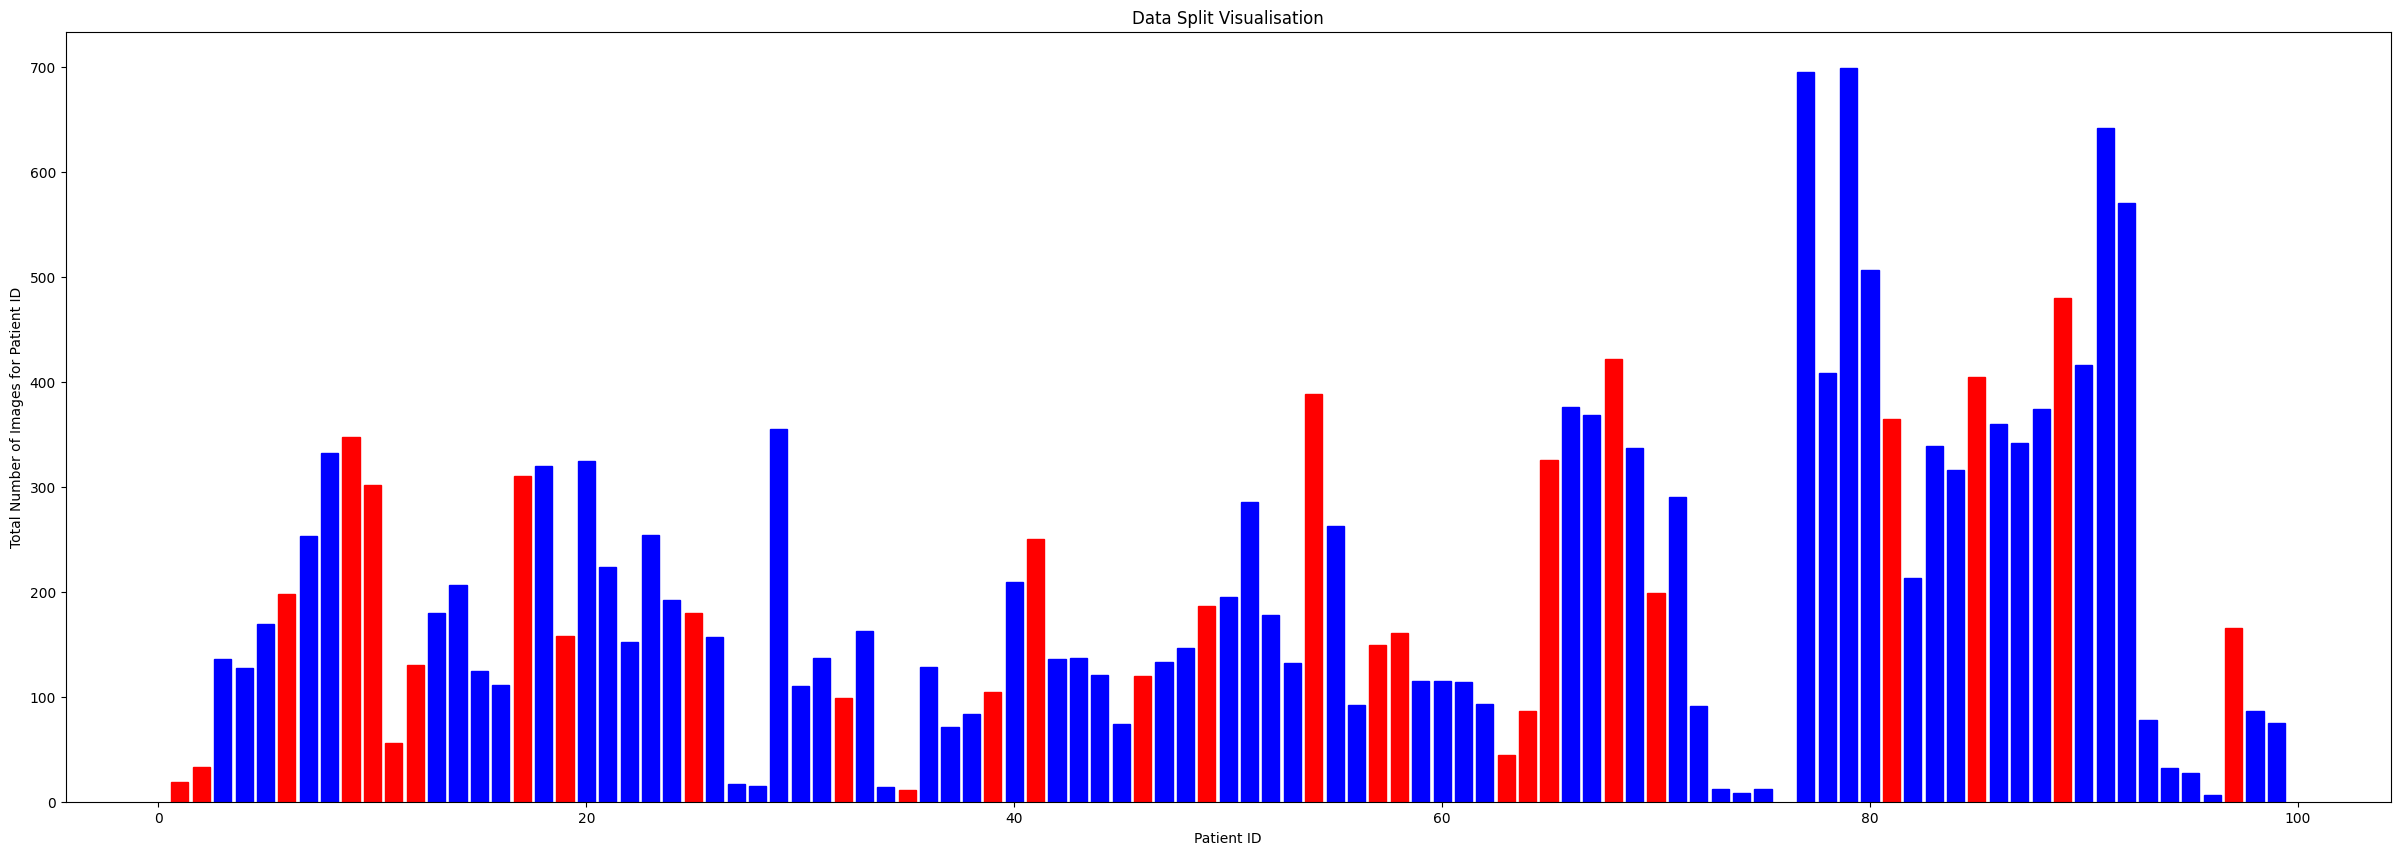

Training Data = BLUE
Average number of Training:  208.0

Testing Data = RED
Average number of Testing:  204.0


In [19]:
training_set = dfPatientImagesCount[dfPatientImagesCount['Patient ID'].isin(trainingPatientID)]
testing_set = dfPatientImagesCount[dfPatientImagesCount['Patient ID'].isin(testingPatientID)] 

training_set['Colour'] = 'blue'
testing_set['Colour'] = 'red'
dfSplitData = pd.concat([training_set, testing_set])
dfSplitData.sort_values(['Patient ID'], ascending=True, inplace=True)


fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.bar(dfSplitData['Patient ID'], dfSplitData['Total Images for Patient'])

for i, bar in enumerate(bars):
    bar.set_color(dfSplitData.iloc[i]['Colour'])

ax.set_xlabel('Patient ID')
ax.set_ylabel('Total Number of Images for Patient ID')
ax.set_title('Data Split Visualisation')

plt.show()

print("Training Data = BLUE")
print("Average number of Training: ", training_set['Total Images for Patient'].mean().round())
print()
print("Testing Data = RED")
print("Average number of Testing: ", testing_set['Total Images for Patient'].mean().round())

# Data for Cell Type Classification

In [20]:
trainingSetCellType = dfMain[dfMain['patientID'].isin(training_set['Patient ID'])]
testingSetCellType = dfMain[dfMain['patientID'].isin(testing_set['Patient ID'])]

# print(trainingSetCellType)
# print()
# print(testingSetCellType)

# Data for Cancerous Classification

In [21]:
trainingSetCancerous = dfJoined[dfJoined['patientID'].isin(training_set['Patient ID'])]
testingSetCancerous = dfJoined[dfJoined['patientID'].isin(testing_set['Patient ID'])]

# print(trainingSetCancerous)
# print()
# print(testingSetCancerous)

In [22]:
dfEpithelial = dfMain.loc[dfMain['cellTypeName'] == 'epithelial']
dfInflammatory = dfMain.loc[dfMain['cellTypeName'] == 'inflammatory']
dfFibroblast = dfMain.loc[dfMain['cellTypeName'] == 'fibroblast']
dfOthers= dfMain.loc[dfMain['cellTypeName'] == 'others']

In [23]:
cancerous = dfMain.loc[dfMain['isCancerous'] == 1]
non_cancerous = dfMain.loc[dfMain['isCancerous'] == 0]
print(cancerous.equals(dfEpithelial))

True


In [24]:
path = 'Image_classification_data/patch_images/' # image folder

In [25]:
dfIsCancerous = dfJoined.loc[dfJoined['isCancerous'] == 1]
print(dfIsCancerous)

      InstanceID  patientID ImageName cellTypeName  cellType  isCancerous
449          276          5   276.png   epithelial       2.0            1
450          277          5   277.png   epithelial       2.0            1
451          278          5   278.png   epithelial       2.0            1
452          279          5   279.png   epithelial       2.0            1
453          280          5   280.png   epithelial       2.0            1
...          ...        ...       ...          ...       ...          ...
7800        7667         88  7667.png          NaN       NaN            1
7801        7668         88  7668.png          NaN       NaN            1
7802        7669         88  7669.png          NaN       NaN            1
7803        7670         88  7670.png          NaN       NaN            1
7804        7671         88  7671.png          NaN       NaN            1

[7069 rows x 6 columns]


In [26]:
dfNotCancerous = dfJoined.loc[dfJoined['isCancerous'] == 0]
print(dfNotCancerous)

       InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0           22405          1  22405.png   fibroblast       0.0            0
1           22406          1  22406.png   fibroblast       0.0            0
2           22407          1  22407.png   fibroblast       0.0            0
3           22408          1  22408.png   fibroblast       0.0            0
4           22409          1  22409.png   fibroblast       0.0            0
...           ...        ...        ...          ...       ...          ...
10379       20028         99  20028.png          NaN       NaN            0
10380       20029         99  20029.png          NaN       NaN            0
10381       20030         99  20030.png          NaN       NaN            0
10382       20031         99  20031.png          NaN       NaN            0
10383       20032         99  20032.png          NaN       NaN            0

[13211 rows x 6 columns]


In [27]:
nonCancerous = dfNotCancerous['ImageName'].tolist()
isCancerous = dfIsCancerous['ImageName'].tolist()

In [28]:
# randomly select 10 of each image from non-cancerous and cancerous lists
select_nonCancerous = np.random.choice(nonCancerous, 10, replace = False)
select_isCancerous = np.random.choice(isCancerous, 10, replace = False)

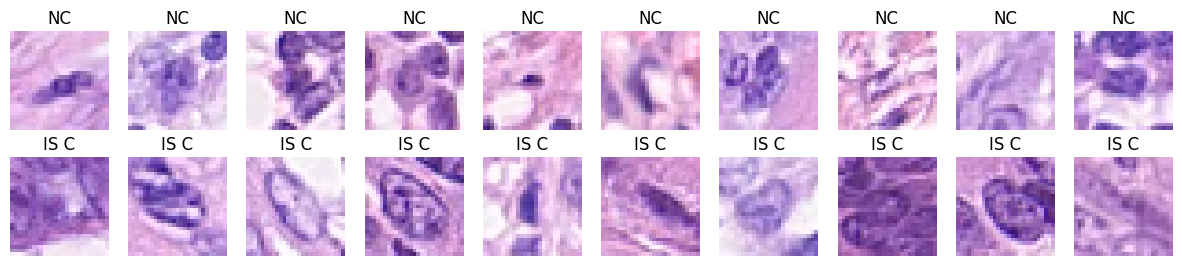

In [29]:
fig = plt.figure(figsize = (15,3))
rows = 2
columns = 12

for i in range(20):
    if i < 10:
        fp = path + select_nonCancerous[i]
        label = 'NC'
    else:
        fp = path + select_isCancerous[i-10]
        label = 'IS C'
        
    ax = fig.add_subplot(2, 10, i+1)
    fn = image.load_img(fp)
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

In [30]:
epithelial = dfEpithelial['ImageName'].tolist()
inflammatory = dfInflammatory['ImageName'].tolist()
fibroblast = dfFibroblast['ImageName'].tolist()
others= dfOthers['ImageName'].tolist()

# # randomly select 10 of each image from each cell type name
selectEpithelial = np.random.choice(epithelial, 10, replace = False)
selectInflammatory = np.random.choice(inflammatory, 10, replace = False)
selectFibroblast = np.random.choice(fibroblast, 10, replace = False)
selectOthers = np.random.choice(others, 10, replace = False)

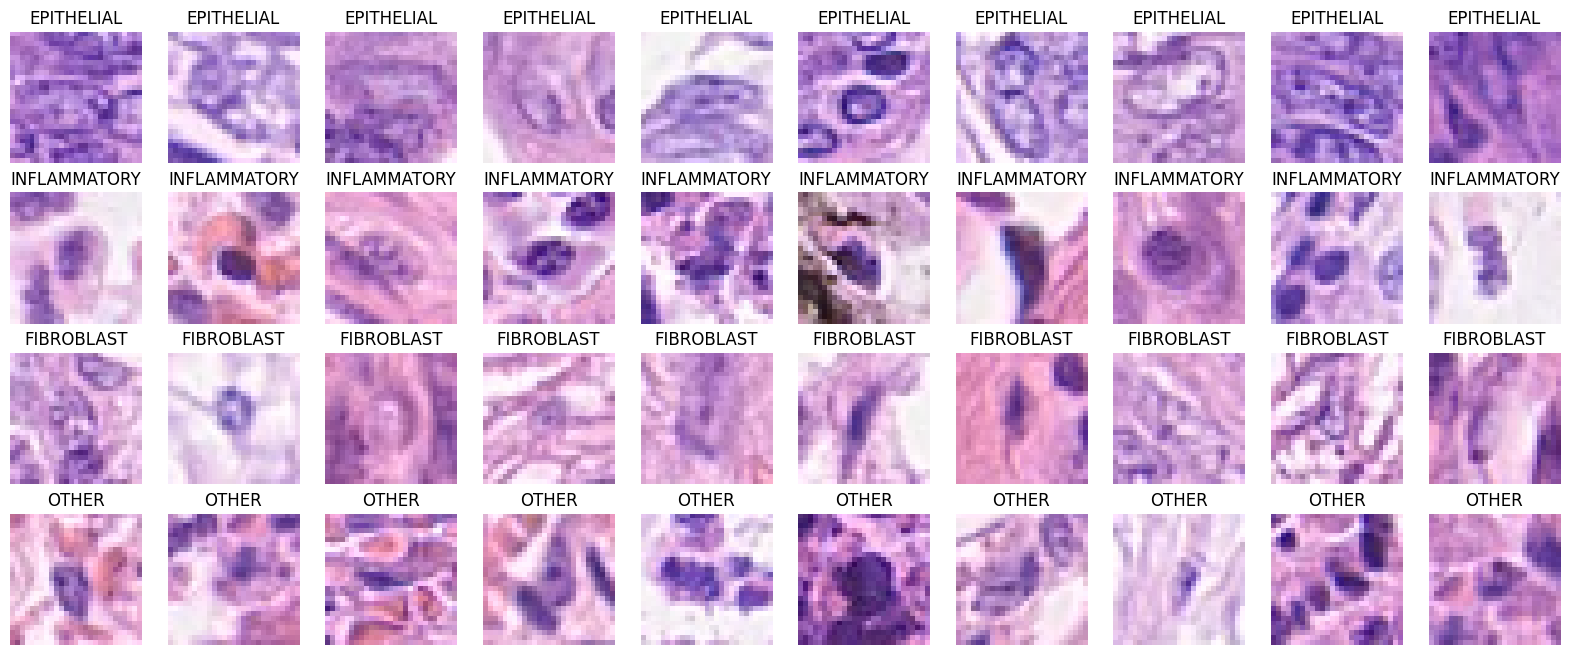

In [31]:
fig = plt.figure(figsize = (20,8))
rows = 4
columns = 12

for i in range(40):
    if i < 10:
        fp = path + selectEpithelial[i]
        label = 'EPITHELIAL'
    elif i < 20 :
        fp = path + selectInflammatory[i-10]
        label = 'INFLAMMATORY'
    elif i < 30 :
        fp = path + selectFibroblast[i-20]
        label = 'FIBROBLAST'
    elif i < 40 :
        fp = path + selectOthers[i-30]
        label = 'OTHER'
        
    ax = fig.add_subplot(4, 10, i+1)
    fn = image.load_img(fp)
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

In [64]:
def readImagesFromList(imgList, mode):
    images = []
    for filename in imgList:      
        img = cv2.imread(path + filename)
        if img is not None and mode == 'gray':
            img_flat = img.flatten()
            images.append(img_flat)
        elif img is not None:
            images.append(img)
    return images

ncImagesGS = readImagesFromList(nonCancerous, 'gray')
icImagesGS = readImagesFromList(isCancerous, 'gray')
ncImagesRGB = readImagesFromList(nonCancerous, None)
icImagesRGB = readImagesFromList(isCancerous, None)

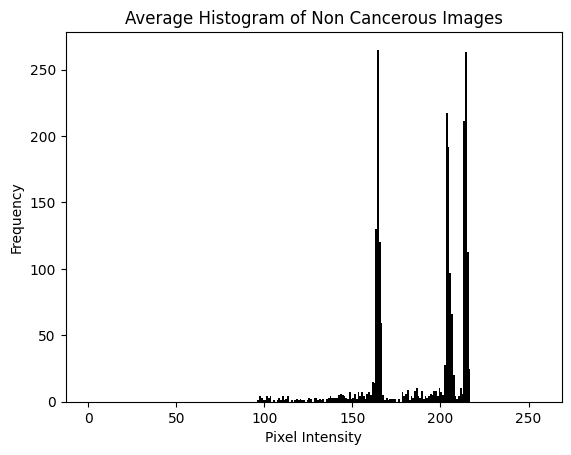

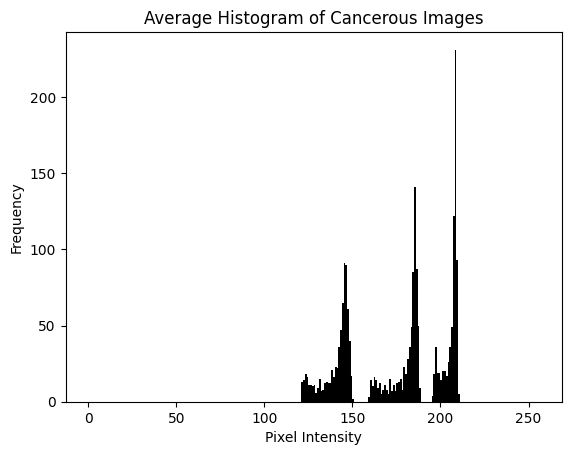

In [65]:
def imageHistograms(images, title):
#     images = read_images_from_list(imgList)
    pixel_values = np.array(images).mean(axis=0)
    plt.hist(pixel_values, bins=256, range=(0, 256), color='k')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

imageHistograms(ncImagesGS, 'Average Histogram of Non Cancerous Images')
imageHistograms(icImagesGS, 'Average Histogram of Cancerous Images')

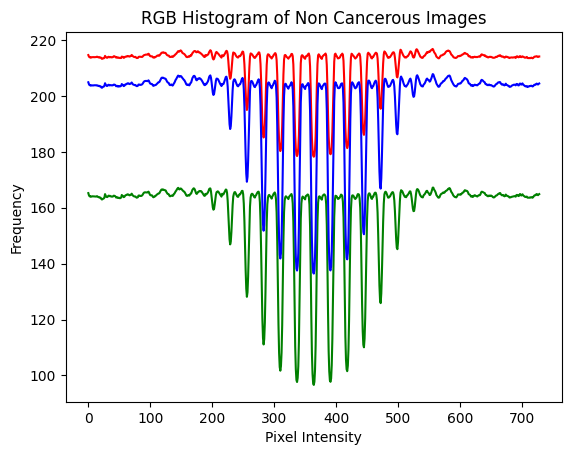

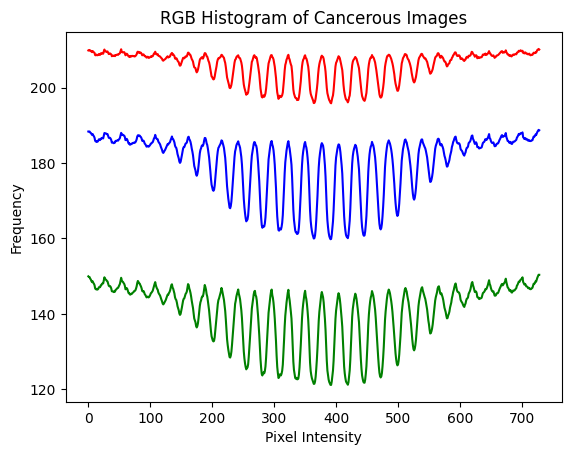

In [66]:
def colouredHistograms(images, title):
    red_values = []
    green_values = []
    blue_values = []

    for img in images:
        red_values.append(img[:,:,0].flatten())
        green_values.append(img[:,:,1].flatten())
        blue_values.append(img[:,:,2].flatten())

    red_values = np.array(red_values).mean(axis=0)
    green_values = np.array(green_values).mean(axis=0)
    blue_values = np.array(blue_values).mean(axis=0)

    plt.plot(red_values, color='r')
    plt.plot(green_values, color='g')
    plt.plot(blue_values, color='b')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

colouredHistograms(ncImagesRGB, 'RGB Histogram of Non Cancerous Images')
colouredHistograms(icImagesRGB, 'RGB Histogram of Cancerous Images')

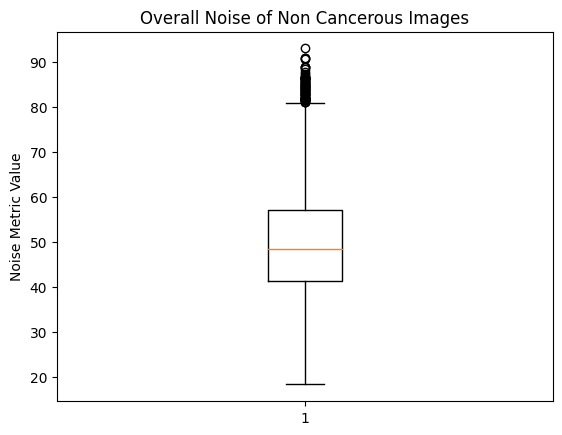

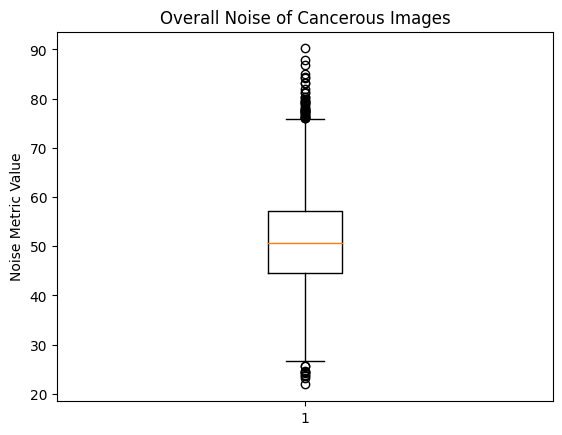

In [71]:
def calculateNoise(image, title):
    overall_noise = []    
    for img in image:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        noise = laplacian.std()
        overall_noise.append(noise)
    
    plt.boxplot(overall_noise)
    plt.title(title)
    plt.ylabel("Noise Metric Value")
    plt.show()

calculateNoise(ncImagesRGB, 'Overall Noise of Non Cancerous Images')
calculateNoise(icImagesRGB, 'Overall Noise of Cancerous Images')

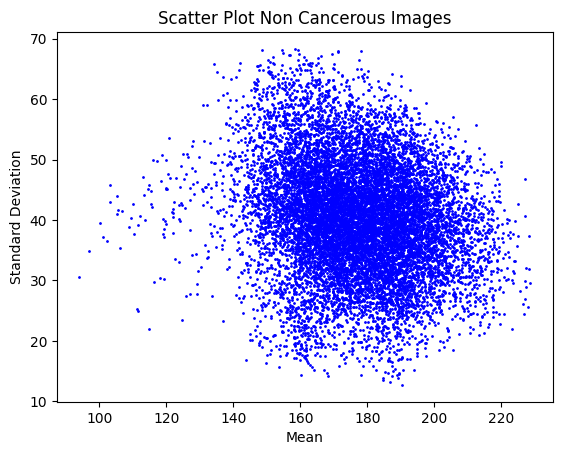

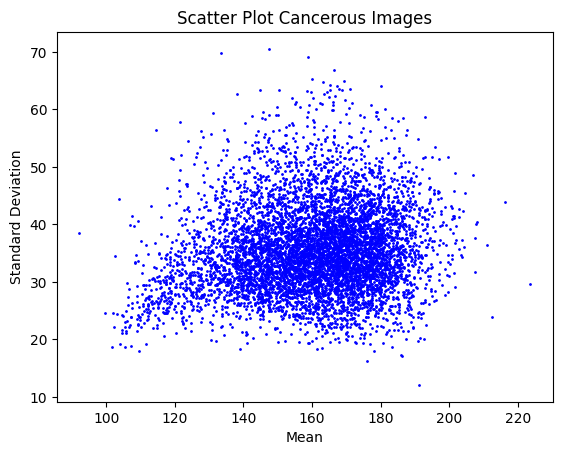

In [80]:
def extractFeatures(image, title):
    x_values = []
    y_values = []
    
    for img in image: 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mean = gray.mean()
        std = gray.std()
        x_values.append(mean)
        y_values.append(std)

    plt.scatter(x_values, y_values, s=1, color='blue')
    plt.title(title)
    plt.xlabel("Mean")
    plt.ylabel("Standard Deviation")
    plt.show()
    
extractFeatures(ncImagesRGB, 'Scatter Plot Non Cancerous Images')
extractFeatures(icImagesRGB, 'Scatter Plot Cancerous Images')

# Baseline Neural Network

In [ ]:
from sklearn.model_selection import train_test_split

with pd.option_context('mode.chained_assignment', None):
    train_data_, test_data = train_test_split(dfMain, test_size=0.2, 
                                              shuffle=True,random_state=0)
    
with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(train_data_, test_size=0.25, 
                                            shuffle=True,random_state=0)
    
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

In [ ]:
train_X = train_data.drop(['isCancerous',], axis=1).to_numpy()
train_y = train_data[['isCancerous']].to_numpy()

test_X = test_data.drop(['isCancerous',], axis=1).to_numpy()
test_y = test_data[['isCancerous']].to_numpy()

val_X = val_data.drop(['isCancerous',], axis=1).to_numpy()
val_y = val_data[['isCancerous']].to_numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
train_data['Class'] = train_data['Class'].astype('str')
val_data['Class'] = val_data['Class'].astype('str')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')


In [ ]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.evaluate(test_generator)

In [ ]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# Baseline Deep Neural Network